In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torch.utils.data import Subset
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
import os
import re
import pickle
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [2]:
class EmbeddingDataset(Dataset):
    def __init__(self, csv_file,embeddings):
        self.data = pd.read_csv(csv_file)
        self.emb = embeddings
        
        # Parse the embeddings from string representations of numpy arrays
        self.input_embeddings_1 = self.data['clip_1'].apply(self.get_stacked_embedding)
        self.input_embeddings_2 = self.data['clip_2'].apply(self.get_stacked_embedding)
        # Convert embeddings into tensors with correct dimensions
        self.embeddings = torch.stack([torch.stack([e1, e2]) for e1, e2 in zip(self.input_embeddings_1, self.input_embeddings_2)])
        
        # Extract labels (assumed to be integers)
        self.labels = torch.tensor(self.data['class'].values)
        self.clip_1_ids = self.data['clip_1'].values
        self.clip_2_ids = self.data['clip_2'].values
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Return embeddings, corresponding label, and clip filenames
        return (
            self.embeddings[idx],
            self.labels[idx],
            {
                'clip_1': self.clip_1_ids[idx],
                'clip_2': self.clip_2_ids[idx]
            }
        )
        
    def get_stacked_embedding(self,clip_id):
        emb = self.emb[clip_id]
        temp= torch.cat([
            torch.tensor(emb['text']),
            torch.tensor(emb['video']),
            torch.tensor(emb['audio'])
        ], dim=0)

        # print(temp.shape)

        return temp

In [3]:
class TransformerClassifier(nn.Module):
    def __init__(self, embed_size=768*2+2048, num_classes=2, num_heads=4, num_layers=2, ff_hid_dim=2048, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        
        self.embed_size = embed_size
        self.num_classes = num_classes
        self.num_heads = num_heads
        self.num_layers = num_layers
        
        # Embedding Layer (input dimension is 2034, sequence length is 2)
        self.embedding = nn.Linear(embed_size, embed_size)
        
        # Positional Encoding
        self.positional_encoding = nn.Parameter(torch.zeros(1, 2, embed_size), requires_grad=False)  # 2 tokens in the sequence
        
        # Transformer Encoder
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_size, nhead=num_heads, dim_feedforward=ff_hid_dim, dropout=dropout),
            num_layers=num_layers
        )
        
        # Classifier Layer (output size = num_classes)
        self.fc_out = nn.Linear(embed_size, num_classes)

    def forward(self, x):
        # x shape: (batch_size, 2, embed_size)
        
        # Apply the embedding layer (not really necessary here, but a placeholder for potential learned embeddings)
        x = self.embedding(x)
        
        # Add positional encoding
        x = x + self.positional_encoding
        
        # Pass through the Transformer Encoder
        transformer_out = self.transformer_encoder(x.transpose(0, 1))  # Transformer expects shape (seq_len, batch_size, embed_size)
        
        # Use the representation of the final token (or the mean of all tokens) for classification
        final_token = transformer_out[-1, :, :]  # Get the last token representation (could also try averaging all tokens)
        
        # Classifier layer to produce class probabilities
        output = self.fc_out(final_token)
        
        # Apply softmax to get probabilities
        return F.log_softmax(output, dim=-1)

In [4]:
def extract_clip_number(clip_id):
    """Extract the clip number from clip_id formats like 45-015-01.mp4 or 1-01-05.mp4"""
    # Extract the first number in the clip_id
    match = re.search(r'^(\d+)', clip_id)
    if match:
        return int(match.group(1))
    return None

In [5]:
def create_clip_based_split(dataset, csv_file):
    """
    Create train/val/test splits based on full clip identifiers (e.g., "45-01"):
    - Split clips with 70% train, 10% val, 20% test
    - Ensure no overlapping clips between splits
    - Ensure clips starting with "12" are always in the test set
    """
    # Load the original dataframe to get clip_id column
    df = pd.read_csv(csv_file)
    
    # Extract full clip identifiers (e.g., "45-01" from "45-01-01")
    def extract_full_clip_id(clip_id):
        parts = clip_id.split('-')
        if len(parts) >= 2:
            return f"{parts[0]}-{parts[1]}"
        return clip_id  # Return original if format is unexpected
        
    # Apply to get all clip IDs
    full_clip_ids = df['clip_1'].apply(extract_full_clip_id).values
    
    # Get unique clip identifiers
    unique_clips = np.unique(full_clip_ids)
    total_unique_clips = len(unique_clips)
    
    # Separate clips starting with "12" to include in test set
    clips_starting_with_12 = np.array([clip for clip in unique_clips if clip.startswith("12")])
    other_clips = np.array([clip for clip in unique_clips if not clip.startswith("12")])
    
    # Calculate number of additional clips needed for test set (20% of total minus clips_starting_with_12)
    num_test_clips_total = int(total_unique_clips * 0.2)
    num_additional_test_clips = max(0, num_test_clips_total - len(clips_starting_with_12))
    
    # Calculate number of clips for validation set (10% of total)
    num_val_clips = int(total_unique_clips * 0.1)
    
    # Make sure we have at least 1 clip for validation
    num_val_clips = max(1, num_val_clips)
    
    print(f"Total unique clips: {total_unique_clips}")
    print(f"Clips starting with '12' (forced into test): {len(clips_starting_with_12)}")
    print(f"Additional test clips needed: {num_additional_test_clips}")
    print(f"Validation clips: {num_val_clips} ({num_val_clips/total_unique_clips:.1%})")
    print(f"Test clips total: {len(clips_starting_with_12) + num_additional_test_clips} ({(len(clips_starting_with_12) + num_additional_test_clips)/total_unique_clips:.1%})")
    print(f"Training clips: {total_unique_clips - (len(clips_starting_with_12) + num_additional_test_clips) - num_val_clips} ({(total_unique_clips - (len(clips_starting_with_12) + num_additional_test_clips) - num_val_clips)/total_unique_clips:.1%})")
    
    # Randomly assign remaining clips to splits
    np.random.seed(42)
    np.random.shuffle(other_clips)
    
    additional_test_clips = other_clips[:num_additional_test_clips]
    val_clips = other_clips[num_additional_test_clips:num_additional_test_clips + num_val_clips]
    train_clips = other_clips[num_additional_test_clips + num_val_clips:]
    
    # Combine clips_starting_with_12 with additional_test_clips for the complete test set
    test_clips = np.concatenate([clips_starting_with_12, additional_test_clips])
    
    # Create indices for each split
    test_indices = np.array([i for i, clip in enumerate(full_clip_ids) if clip in test_clips])
    val_indices = np.array([i for i, clip in enumerate(full_clip_ids) if clip in val_clips])
    train_indices = np.array([i for i, clip in enumerate(full_clip_ids) if clip in train_clips])
    
    # Check sample distribution in each split
    print(f"\nSplit by samples:")
    print(f"Train: {len(train_indices)} samples ({len(train_indices)/len(df):.1%})")
    print(f"Val: {len(val_indices)} samples ({len(val_indices)/len(df):.1%})")
    print(f"Test: {len(test_indices)} samples ({len(test_indices)/len(df):.1%})")
    
    # Check class distribution in each split
    train_labels = dataset.labels[train_indices].numpy()
    val_labels = dataset.labels[val_indices].numpy()
    test_labels = dataset.labels[test_indices].numpy()
    
    print(f"\nClass distribution:")
    print(f"Train - Class 0: {np.sum(train_labels == 0)}, Class 1: {np.sum(train_labels == 1)}, Total: {len(train_indices)}")
    print(f"Val   - Class 0: {np.sum(val_labels == 0)}, Class 1: {np.sum(val_labels == 1)}, Total: {len(val_indices)}")
    print(f"Test  - Class 0: {np.sum(test_labels == 0)}, Class 1: {np.sum(test_labels == 1)}, Total: {len(test_indices)}")
    
    # Show some examples of clips in each split
    print(f"\nExample clips in each split:")
    print(f"Train clips (first 5): {train_clips[:5]}")
    print(f"Val clips: {val_clips}")
    print(f"Test clips with '12' prefix: {clips_starting_with_12}")
    print(f"Additional test clips (first 5): {additional_test_clips[:5] if len(additional_test_clips) > 0 else '[]'}")
    
    return train_indices, val_indices, test_indices

In [6]:
batch_size = 32
embed_size = 768*2+2048
num_classes = 2
sequence_length = 2  # 2 embeddings per data point

In [7]:
import pickle

# Path to your pickle file
file_path = '/kaggle/input/dataset-embs/combined_embeddings.pkl'

# Open and load the pickle file
with open(file_path, 'rb') as f:
    embs = pickle.load(f)

In [8]:
# Function to create balanced train/val/test splits
def create_balanced_dataset(dataset, train_indices):
    """
    Create a balanced dataset with equal number of samples from each class
    Using only the samples identified by train_indices
    """
    # Get the original dataset's labels
    all_labels = dataset.labels.numpy()
    
    # Filter to only use the labels from train_indices
    labels = all_labels[train_indices]
    
    # Get indices for each class (these are indices within train_indices)
    class_0_mask = labels == 0
    class_1_mask = labels == 1
    
    class_0_indices_local = np.where(class_0_mask)[0]  # Local indices within train_indices
    class_1_indices_local = np.where(class_1_mask)[0]  # Local indices within train_indices
    
    print(f"Original dataset - Class 0: {len(class_0_indices_local)}, Class 1: {len(class_1_indices_local)}")
    
    # Determine the minimum count to ensure balance
    min_count = min(len(class_0_indices_local), len(class_1_indices_local))
    
    # Randomly select indices to get equal numbers
    np.random.seed(42)  # for reproducibility
    if len(class_0_indices_local) > min_count:
        class_0_indices_local = np.random.choice(class_0_indices_local, min_count, replace=False)
    if len(class_1_indices_local) > min_count:
        class_1_indices_local = np.random.choice(class_1_indices_local, min_count, replace=False)
    
    # Map local indices back to actual train_indices
    class_0_indices = train_indices[class_0_indices_local]
    class_1_indices = train_indices[class_1_indices_local]
    
    # Combine the indices for the balanced dataset
    balanced_indices = np.concatenate([class_0_indices, class_1_indices])
    
    # Shuffle the indices
    np.random.shuffle(balanced_indices)
    
    print(f"Balanced dataset - Class 0: {min_count}, Class 1: {min_count}, Total: {2*min_count}")
    
    return balanced_indices


# Function to create balanced train/val/test splits
def create_balanced_splits(dataset, balanced_indices, train_size=0.75, val_size=0.25, test_size=0.0):
    """
    Create balanced train/val/test splits from the balanced dataset indices
    """
    # Get labels for the balanced indices
    balanced_labels = dataset.labels[balanced_indices].numpy()
    
    train_indices, val_indices, train_labels, val_labels = train_test_split(
        balanced_indices, balanced_labels, test_size=(val_size + test_size), 
        stratify=balanced_labels, random_state=42
    )
    
    # # Split temp into val and test
    # val_ratio = val_size / (val_size + test_size)
    # val_indices, test_indices, val_labels, test_labels = train_test_split(
    #     temp_indices, temp_labels, test_size=(1-val_ratio),
    #     stratify=temp_labels, random_state=42
    # )
    
    # Check class distribution in each split
    train_labels = dataset.labels[train_indices].numpy()
    val_labels = dataset.labels[val_indices].numpy()
    test_labels = dataset.labels[test_indices].numpy()
    
    print(f"Train - Class 0: {np.sum(train_labels == 0)}, Class 1: {np.sum(train_labels == 1)}, Total: {len(train_indices)}")
    print(f"Val   - Class 0: {np.sum(val_labels == 0)}, Class 1: {np.sum(val_labels == 1)}, Total: {len(val_indices)}")
    # print(f"Test  - Class 0: {np.sum(test_labels == 0)}, Class 1: {np.sum(test_labels == 1)}, Total: {len(test_indices)}")
    
    return train_indices, val_indices

# Function to save model
def save_checkpoint(model, optimizer, epoch, loss, accuracy, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch} to {filename}")

# Create a directory to save models if it doesn't exist
save_dir = '/kaggle/working/'
os.makedirs(save_dir, exist_ok=True)

In [9]:
# Path to the CSV file containing the data
csv_file = '/kaggle/input/dataset-embs/combined_data.csv'

dataset = EmbeddingDataset(csv_file,embs)

train_indices, val_indices,test_indices = create_clip_based_split(dataset, csv_file)
    

train_balanced_indices = create_balanced_dataset(dataset,train_indices)
val_balanced_indices = create_balanced_dataset(dataset,val_indices)
test_balanced_indices = create_balanced_dataset(dataset,test_indices)

# Create train/val/test splits from the balanced dataset
# train_indices, val_indices= create_balanced_splits(dataset, train_balanced_indices)

Total unique clips: 962
Clips starting with '12' (forced into test): 9
Additional test clips needed: 183
Validation clips: 96 (10.0%)
Test clips total: 192 (20.0%)
Training clips: 674 (70.1%)

Split by samples:
Train: 4702 samples (70.0%)
Val: 898 samples (13.4%)
Test: 1119 samples (16.7%)

Class distribution:
Train - Class 0: 3931, Class 1: 771, Total: 4702
Val   - Class 0: 788, Class 1: 110, Total: 898
Test  - Class 0: 907, Class 1: 212, Total: 1119

Example clips in each split:
Train clips (first 5): ['25-016' '45-009' '42-011' '29-001' '5-020']
Val clips: ['9-073' '42-013' '32-007' '10-020' '10-018' '39-011' '21-035' '34-027'
 '22-019' '32-005' '32-017' '16-022' '13-002' '34-016' '7-002' '13-013'
 '45-012' '24-027' '9-027' '34-010' '1-003' '16-014' '31-001' '27-001'
 '45-014' '19-052' '1-015' '10-056' '21-026' '45-001' '25-006' '39-012'
 '14-034' '33-016' '35-006' '20-035' '34-017' '9-031' '44-011' '23-003'
 '44-013' '10-012' '13-015' '1-031' '4-013' '31-008' '24-010' '38-007'
 '31

In [10]:
train_sampler = SubsetRandomSampler(train_balanced_indices)
val_sampler = SubsetRandomSampler(val_balanced_indices)
test_sampler = SubsetRandomSampler(test_indices)
test_balanced_sampler = SubsetRandomSampler(test_balanced_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
test_balanced_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_balanced_sampler)

In [11]:
# Save the indices
indices_dict = {
    'train_indices': train_indices,
    'val_indices': val_indices,
    'test_indices': test_indices,
    'test_balanced_indices': test_balanced_indices
}

with open('indices.pkl', 'wb') as f:
    pickle.dump(indices_dict, f)

# Save the data loaders
loaders_dict = {
    'train_loader': train_loader,
    'val_loader': val_loader,
    'test_loader': test_loader,
    'test_balanced_loader': test_balanced_loader
}

with open('dataloaders.pkl', 'wb') as f:
    pickle.dump(loaders_dict, f)

In [12]:
model = TransformerClassifier(embed_size=embed_size, num_classes=num_classes).to(device)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [13]:
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [14]:
def calculate_per_class_metrics(targets, predictions):
    """
    Calculate precision, recall, and F1 score for each class
    """
    # For weighted average
    weighted_precision = precision_score(targets, predictions, average='weighted', zero_division=0)
    weighted_recall = recall_score(targets, predictions, average='weighted', zero_division=0)
    weighted_f1 = f1_score(targets, predictions, average='weighted', zero_division=0)
    
    # For each class specifically
    per_class_precision = precision_score(targets, predictions, average=None, zero_division=0)
    per_class_recall = recall_score(targets, predictions, average=None, zero_division=0)
    per_class_f1 = f1_score(targets, predictions, average=None, zero_division=0)
    
    return {
        'weighted': {
            'precision': weighted_precision,
            'recall': weighted_recall,
            'f1': weighted_f1
        },
        'per_class': {
            'precision': per_class_precision,
            'recall': per_class_recall,
            'f1': per_class_f1
        }
    }

In [15]:
def evaluate(model, data_loader, device, print_metrics=False):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets,_ in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            running_loss += loss.item()
            
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            # Store predictions and targets for metric calculation
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
    # Calculate metrics
    accuracy = 100 * correct / total
    avg_loss = running_loss / len(data_loader)
    
    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    # Calculate per-class and weighted metrics
    metrics = calculate_per_class_metrics(all_targets, all_predictions)
    
    if print_metrics:
        print(f"Accuracy: {accuracy:.2f}%")
        print("\nWeighted Metrics:")
        print(f"  Precision: {metrics['weighted']['precision']:.4f}")
        print(f"  Recall: {metrics['weighted']['recall']:.4f}")
        print(f"  F1 Score: {metrics['weighted']['f1']:.4f}")
        
        print("\nPer-Class Metrics:")
        print(f"  Class 0 - Precision: {metrics['per_class']['precision'][0]:.4f}, Recall: {metrics['per_class']['recall'][0]:.4f}, F1: {metrics['per_class']['f1'][0]:.4f}")
        print(f"  Class 1 - Precision: {metrics['per_class']['precision'][1]:.4f}, Recall: {metrics['per_class']['recall'][1]:.4f}, F1: {metrics['per_class']['f1'][1]:.4f}")
        
        # Print detailed classification report
        print("\nClassification Report:")
        print(classification_report(all_targets, all_predictions, zero_division=0))
        
        # Print confusion matrix
        print("\nConfusion Matrix:")
        cm = confusion_matrix(all_targets, all_predictions)
        print(cm)
        
        # Detailed explanation of confusion matrix
        tn, fp, fn, tp = cm.ravel()
        print(f"\nConfusion Matrix Explanation:")
        print(f"  True Negatives (Class 0 correctly predicted): {tn}")
        print(f"  False Positives (Class 0 incorrectly predicted as Class 1): {fp}")
        print(f"  False Negatives (Class 1 incorrectly predicted as Class 0): {fn}")
        print(f"  True Positives (Class 1 correctly predicted): {tp}")
    
    return avg_loss, accuracy, metrics

Epoch 1/30: 100%|██████████| 49/49 [00:04<00:00, 11.17it/s]


Epoch [1/30]
  Train - Loss: 1.1302, Acc: 51.36%
    Class 0 - Precision: 0.5139, Recall: 0.5045, F1: 0.5092
    Class 1 - Precision: 0.5134, Recall: 0.5227, F1: 0.5180
  Val   - Loss: 0.7057, Acc: 55.45%
    Class 0 - Precision: 0.5294, Recall: 0.9818, F1: 0.6879
    Class 1 - Precision: 0.8750, Recall: 0.1273, F1: 0.2222
Checkpoint saved at epoch 1 to /kaggle/working/model_best.pt
New best model saved with average validation F1 score: 0.4551


Epoch 2/30: 100%|██████████| 49/49 [00:03<00:00, 15.91it/s]


Epoch [2/30]
  Train - Loss: 0.6449, Acc: 63.29%
    Class 0 - Precision: 0.6248, Recall: 0.6654, F1: 0.6445
    Class 1 - Precision: 0.6422, Recall: 0.6005, F1: 0.6206
  Val   - Loss: 0.8161, Acc: 65.00%
    Class 0 - Precision: 0.8235, Recall: 0.3818, F1: 0.5217
    Class 1 - Precision: 0.5976, Recall: 0.9182, F1: 0.7240
Checkpoint saved at epoch 2 to /kaggle/working/model_best.pt
New best model saved with average validation F1 score: 0.6229


Epoch 3/30: 100%|██████████| 49/49 [00:03<00:00, 15.85it/s]


Epoch [3/30]
  Train - Loss: 0.5607, Acc: 71.01%
    Class 0 - Precision: 0.7269, Recall: 0.6732, F1: 0.6990
    Class 1 - Precision: 0.6957, Recall: 0.7471, F1: 0.7205
  Val   - Loss: 0.7700, Acc: 57.73%
    Class 0 - Precision: 0.5440, Recall: 0.9545, F1: 0.6931
    Class 1 - Precision: 0.8148, Recall: 0.2000, F1: 0.3212


Epoch 4/30: 100%|██████████| 49/49 [00:03<00:00, 16.18it/s]


Epoch [4/30]
  Train - Loss: 0.4728, Acc: 76.85%
    Class 0 - Precision: 0.7767, Recall: 0.7536, F1: 0.7650
    Class 1 - Precision: 0.7607, Recall: 0.7834, F1: 0.7719
  Val   - Loss: 0.6193, Acc: 69.09%
    Class 0 - Precision: 0.6641, Recall: 0.7727, F1: 0.7143
    Class 1 - Precision: 0.7283, Recall: 0.6091, F1: 0.6634
Checkpoint saved at epoch 4 to /kaggle/working/model_best.pt
New best model saved with average validation F1 score: 0.6888


Epoch 5/30: 100%|██████████| 49/49 [00:03<00:00, 15.86it/s]


Epoch [5/30]
  Train - Loss: 0.3927, Acc: 81.00%
    Class 0 - Precision: 0.8310, Recall: 0.7782, F1: 0.8038
    Class 1 - Precision: 0.7915, Recall: 0.8418, F1: 0.8158
  Val   - Loss: 0.6187, Acc: 69.55%
    Class 0 - Precision: 0.6777, Recall: 0.7455, F1: 0.7100
    Class 1 - Precision: 0.7172, Recall: 0.6455, F1: 0.6794
Checkpoint saved at epoch 5 to /kaggle/working/model_epoch_5.pt
Checkpoint saved at epoch 5 to /kaggle/working/model_best.pt
New best model saved with average validation F1 score: 0.6947


Epoch 6/30: 100%|██████████| 49/49 [00:03<00:00, 15.85it/s]


Epoch [6/30]
  Train - Loss: 0.3420, Acc: 86.38%
    Class 0 - Precision: 0.8755, Recall: 0.8482, F1: 0.8617
    Class 1 - Precision: 0.8528, Recall: 0.8794, F1: 0.8659
  Val   - Loss: 0.6992, Acc: 66.82%
    Class 0 - Precision: 0.6149, Recall: 0.9000, F1: 0.7306
    Class 1 - Precision: 0.8136, Recall: 0.4364, F1: 0.5680


Epoch 7/30: 100%|██████████| 49/49 [00:03<00:00, 16.11it/s]


Epoch [7/30]
  Train - Loss: 0.3184, Acc: 85.28%
    Class 0 - Precision: 0.8598, Recall: 0.8431, F1: 0.8513
    Class 1 - Precision: 0.8461, Recall: 0.8625, F1: 0.8542
  Val   - Loss: 0.8494, Acc: 63.64%
    Class 0 - Precision: 0.5893, Recall: 0.9000, F1: 0.7122
    Class 1 - Precision: 0.7885, Recall: 0.3727, F1: 0.5062


Epoch 8/30: 100%|██████████| 49/49 [00:03<00:00, 16.08it/s]


Epoch [8/30]
  Train - Loss: 0.3153, Acc: 86.19%
    Class 0 - Precision: 0.8623, Recall: 0.8612, F1: 0.8618
    Class 1 - Precision: 0.8614, Recall: 0.8625, F1: 0.8620
  Val   - Loss: 0.8550, Acc: 71.82%
    Class 0 - Precision: 0.7400, Recall: 0.6727, F1: 0.7048
    Class 1 - Precision: 0.7000, Recall: 0.7636, F1: 0.7304
Checkpoint saved at epoch 8 to /kaggle/working/model_best.pt
New best model saved with average validation F1 score: 0.7176


Epoch 9/30: 100%|██████████| 49/49 [00:03<00:00, 15.92it/s]


Epoch [9/30]
  Train - Loss: 0.2734, Acc: 90.01%
    Class 0 - Precision: 0.9065, Recall: 0.8923, F1: 0.8993
    Class 1 - Precision: 0.8940, Recall: 0.9079, F1: 0.9009
  Val   - Loss: 0.7802, Acc: 55.00%
    Class 0 - Precision: 0.9231, Recall: 0.1091, F1: 0.1951
    Class 1 - Precision: 0.5266, Recall: 0.9909, F1: 0.6877


Epoch 10/30: 100%|██████████| 49/49 [00:03<00:00, 16.06it/s]


Epoch [10/30]
  Train - Loss: 0.2827, Acc: 87.68%
    Class 0 - Precision: 0.8663, Recall: 0.8911, F1: 0.8785
    Class 1 - Precision: 0.8879, Recall: 0.8625, F1: 0.8750
  Val   - Loss: 0.7280, Acc: 70.00%
    Class 0 - Precision: 0.7037, Recall: 0.6909, F1: 0.6972
    Class 1 - Precision: 0.6964, Recall: 0.7091, F1: 0.7027
Checkpoint saved at epoch 10 to /kaggle/working/model_epoch_10.pt


Epoch 11/30: 100%|██████████| 49/49 [00:03<00:00, 15.80it/s]


Epoch [11/30]
  Train - Loss: 0.1692, Acc: 93.64%
    Class 0 - Precision: 0.9422, Recall: 0.9300, F1: 0.9360
    Class 1 - Precision: 0.9309, Recall: 0.9429, F1: 0.9369
  Val   - Loss: 0.9451, Acc: 68.18%
    Class 0 - Precision: 0.7174, Recall: 0.6000, F1: 0.6535
    Class 1 - Precision: 0.6562, Recall: 0.7636, F1: 0.7059


Epoch 12/30: 100%|██████████| 49/49 [00:03<00:00, 16.04it/s]


Epoch [12/30]
  Train - Loss: 0.2269, Acc: 91.44%
    Class 0 - Precision: 0.9133, Recall: 0.9157, F1: 0.9145
    Class 1 - Precision: 0.9155, Recall: 0.9131, F1: 0.9143
  Val   - Loss: 0.8221, Acc: 72.73%
    Class 0 - Precision: 0.7358, Recall: 0.7091, F1: 0.7222
    Class 1 - Precision: 0.7193, Recall: 0.7455, F1: 0.7321
Checkpoint saved at epoch 12 to /kaggle/working/model_best.pt
New best model saved with average validation F1 score: 0.7272


Epoch 13/30: 100%|██████████| 49/49 [00:03<00:00, 15.86it/s]


Epoch [13/30]
  Train - Loss: 0.1874, Acc: 93.32%
    Class 0 - Precision: 0.9349, Recall: 0.9313, F1: 0.9331
    Class 1 - Precision: 0.9315, Recall: 0.9351, F1: 0.9333
  Val   - Loss: 1.3343, Acc: 69.55%
    Class 0 - Precision: 0.7867, Recall: 0.5364, F1: 0.6378
    Class 1 - Precision: 0.6483, Recall: 0.8545, F1: 0.7373


Epoch 14/30: 100%|██████████| 49/49 [00:03<00:00, 15.97it/s]


Epoch [14/30]
  Train - Loss: 0.1684, Acc: 93.13%
    Class 0 - Precision: 0.9381, Recall: 0.9235, F1: 0.9307
    Class 1 - Precision: 0.9246, Recall: 0.9390, F1: 0.9318
  Val   - Loss: 0.9145, Acc: 70.45%
    Class 0 - Precision: 0.7848, Recall: 0.5636, F1: 0.6561
    Class 1 - Precision: 0.6596, Recall: 0.8455, F1: 0.7410


Epoch 15/30: 100%|██████████| 49/49 [00:03<00:00, 15.94it/s]


Epoch [15/30]
  Train - Loss: 0.1901, Acc: 92.35%
    Class 0 - Precision: 0.9302, Recall: 0.9157, F1: 0.9229
    Class 1 - Precision: 0.9170, Recall: 0.9313, F1: 0.9241
  Val   - Loss: 1.0932, Acc: 72.27%
    Class 0 - Precision: 0.8182, Recall: 0.5727, F1: 0.6738
    Class 1 - Precision: 0.6713, Recall: 0.8727, F1: 0.7589
Checkpoint saved at epoch 15 to /kaggle/working/model_epoch_15.pt


Epoch 16/30: 100%|██████████| 49/49 [00:03<00:00, 15.75it/s]


Epoch [16/30]
  Train - Loss: 0.1153, Acc: 94.81%
    Class 0 - Precision: 0.9552, Recall: 0.9403, F1: 0.9477
    Class 1 - Precision: 0.9413, Recall: 0.9559, F1: 0.9485
  Val   - Loss: 0.9750, Acc: 69.55%
    Class 0 - Precision: 0.6593, Recall: 0.8091, F1: 0.7265
    Class 1 - Precision: 0.7529, Recall: 0.5818, F1: 0.6564


Epoch 17/30: 100%|██████████| 49/49 [00:03<00:00, 15.83it/s]


Epoch [17/30]
  Train - Loss: 0.1242, Acc: 95.46%
    Class 0 - Precision: 0.9511, Recall: 0.9585, F1: 0.9548
    Class 1 - Precision: 0.9582, Recall: 0.9507, F1: 0.9544
  Val   - Loss: 0.9695, Acc: 68.18%
    Class 0 - Precision: 0.8704, Recall: 0.4273, F1: 0.5732
    Class 1 - Precision: 0.6205, Recall: 0.9364, F1: 0.7464


Epoch 18/30: 100%|██████████| 49/49 [00:03<00:00, 15.90it/s]


Epoch [18/30]
  Train - Loss: 0.2727, Acc: 90.40%
    Class 0 - Precision: 0.9115, Recall: 0.8949, F1: 0.9031
    Class 1 - Precision: 0.8968, Recall: 0.9131, F1: 0.9049
  Val   - Loss: 0.8364, Acc: 69.55%
    Class 0 - Precision: 0.7263, Recall: 0.6273, F1: 0.6732
    Class 1 - Precision: 0.6720, Recall: 0.7636, F1: 0.7149


Epoch 19/30: 100%|██████████| 49/49 [00:03<00:00, 15.89it/s]


Epoch [19/30]
  Train - Loss: 0.1746, Acc: 93.13%
    Class 0 - Precision: 0.9427, Recall: 0.9183, F1: 0.9304
    Class 1 - Precision: 0.9204, Recall: 0.9442, F1: 0.9321
  Val   - Loss: 1.0503, Acc: 68.18%
    Class 0 - Precision: 0.7041, Recall: 0.6273, F1: 0.6635
    Class 1 - Precision: 0.6639, Recall: 0.7364, F1: 0.6983


Epoch 20/30: 100%|██████████| 49/49 [00:03<00:00, 15.88it/s]


Epoch [20/30]
  Train - Loss: 0.1878, Acc: 92.74%
    Class 0 - Precision: 0.9353, Recall: 0.9183, F1: 0.9267
    Class 1 - Precision: 0.9197, Recall: 0.9364, F1: 0.9280
  Val   - Loss: 0.8551, Acc: 73.64%
    Class 0 - Precision: 0.7364, Recall: 0.7364, F1: 0.7364
    Class 1 - Precision: 0.7364, Recall: 0.7364, F1: 0.7364
Checkpoint saved at epoch 20 to /kaggle/working/model_epoch_20.pt
Checkpoint saved at epoch 20 to /kaggle/working/model_best.pt
New best model saved with average validation F1 score: 0.7364


Epoch 21/30: 100%|██████████| 49/49 [00:03<00:00, 15.63it/s]


Epoch [21/30]
  Train - Loss: 0.1075, Acc: 95.98%
    Class 0 - Precision: 0.9598, Recall: 0.9598, F1: 0.9598
    Class 1 - Precision: 0.9598, Recall: 0.9598, F1: 0.9598
  Val   - Loss: 1.0286, Acc: 70.00%
    Class 0 - Precision: 0.8235, Recall: 0.5091, F1: 0.6292
    Class 1 - Precision: 0.6447, Recall: 0.8909, F1: 0.7481


Epoch 22/30: 100%|██████████| 49/49 [00:03<00:00, 15.80it/s]


Epoch [22/30]
  Train - Loss: 0.3388, Acc: 85.34%
    Class 0 - Precision: 0.8394, Recall: 0.8742, F1: 0.8564
    Class 1 - Precision: 0.8687, Recall: 0.8327, F1: 0.8503
  Val   - Loss: 1.0857, Acc: 64.09%
    Class 0 - Precision: 0.8444, Recall: 0.3455, F1: 0.4903
    Class 1 - Precision: 0.5886, Recall: 0.9364, F1: 0.7228


Epoch 23/30: 100%|██████████| 49/49 [00:03<00:00, 15.78it/s]


Epoch [23/30]
  Train - Loss: 0.5421, Acc: 74.77%
    Class 0 - Precision: 0.7690, Recall: 0.7082, F1: 0.7373
    Class 1 - Precision: 0.7296, Recall: 0.7873, F1: 0.7573
  Val   - Loss: 0.6570, Acc: 71.82%
    Class 0 - Precision: 0.7667, Recall: 0.6273, F1: 0.6900
    Class 1 - Precision: 0.6846, Recall: 0.8091, F1: 0.7417


Epoch 24/30: 100%|██████████| 49/49 [00:03<00:00, 15.70it/s]


Epoch [24/30]
  Train - Loss: 0.2602, Acc: 89.30%
    Class 0 - Precision: 0.9029, Recall: 0.8807, F1: 0.8917
    Class 1 - Precision: 0.8835, Recall: 0.9053, F1: 0.8943
  Val   - Loss: 0.7159, Acc: 74.55%
    Class 0 - Precision: 0.7872, Recall: 0.6727, F1: 0.7255
    Class 1 - Precision: 0.7143, Recall: 0.8182, F1: 0.7627
Checkpoint saved at epoch 24 to /kaggle/working/model_best.pt
New best model saved with average validation F1 score: 0.7441


Epoch 25/30: 100%|██████████| 49/49 [00:03<00:00, 15.53it/s]


Epoch [25/30]
  Train - Loss: 0.2211, Acc: 90.73%
    Class 0 - Precision: 0.9164, Recall: 0.8962, F1: 0.9062
    Class 1 - Precision: 0.8985, Recall: 0.9183, F1: 0.9083
  Val   - Loss: 0.8448, Acc: 71.36%
    Class 0 - Precision: 0.6942, Recall: 0.7636, F1: 0.7273
    Class 1 - Precision: 0.7374, Recall: 0.6636, F1: 0.6986
Checkpoint saved at epoch 25 to /kaggle/working/model_epoch_25.pt


Epoch 26/30: 100%|██████████| 49/49 [00:03<00:00, 15.57it/s]


Epoch [26/30]
  Train - Loss: 0.2059, Acc: 91.57%
    Class 0 - Precision: 0.9268, Recall: 0.9027, F1: 0.9146
    Class 1 - Precision: 0.9052, Recall: 0.9287, F1: 0.9168
  Val   - Loss: 0.6815, Acc: 75.00%
    Class 0 - Precision: 0.8161, Recall: 0.6455, F1: 0.7208
    Class 1 - Precision: 0.7068, Recall: 0.8545, F1: 0.7737
Checkpoint saved at epoch 26 to /kaggle/working/model_best.pt
New best model saved with average validation F1 score: 0.7472


Epoch 27/30: 100%|██████████| 49/49 [00:03<00:00, 15.52it/s]


Epoch [27/30]
  Train - Loss: 0.1523, Acc: 93.84%
    Class 0 - Precision: 0.9401, Recall: 0.9364, F1: 0.9383
    Class 1 - Precision: 0.9367, Recall: 0.9403, F1: 0.9385
  Val   - Loss: 0.9477, Acc: 65.45%
    Class 0 - Precision: 0.8696, Recall: 0.3636, F1: 0.5128
    Class 1 - Precision: 0.5977, Recall: 0.9455, F1: 0.7324


Epoch 28/30: 100%|██████████| 49/49 [00:03<00:00, 15.64it/s]


Epoch [28/30]
  Train - Loss: 0.2448, Acc: 88.78%
    Class 0 - Precision: 0.9107, Recall: 0.8599, F1: 0.8846
    Class 1 - Precision: 0.8673, Recall: 0.9157, F1: 0.8909
  Val   - Loss: 0.8628, Acc: 72.73%
    Class 0 - Precision: 0.8571, Recall: 0.5455, F1: 0.6667
    Class 1 - Precision: 0.6667, Recall: 0.9091, F1: 0.7692


Epoch 29/30: 100%|██████████| 49/49 [00:03<00:00, 15.60it/s]


Epoch [29/30]
  Train - Loss: 0.1251, Acc: 95.40%
    Class 0 - Precision: 0.9654, Recall: 0.9416, F1: 0.9534
    Class 1 - Precision: 0.9430, Recall: 0.9663, F1: 0.9545
  Val   - Loss: 0.9823, Acc: 70.00%
    Class 0 - Precision: 0.6930, Recall: 0.7182, F1: 0.7054
    Class 1 - Precision: 0.7075, Recall: 0.6818, F1: 0.6944


Epoch 30/30: 100%|██████████| 49/49 [00:03<00:00, 15.57it/s]


Epoch [30/30]
  Train - Loss: 0.1243, Acc: 95.98%
    Class 0 - Precision: 0.9720, Recall: 0.9468, F1: 0.9593
    Class 1 - Precision: 0.9482, Recall: 0.9728, F1: 0.9603
  Val   - Loss: 0.8555, Acc: 70.00%
    Class 0 - Precision: 0.7619, Recall: 0.5818, F1: 0.6598
    Class 1 - Precision: 0.6618, Recall: 0.8182, F1: 0.7317
Checkpoint saved at epoch 30 to /kaggle/working/model_epoch_30.pt


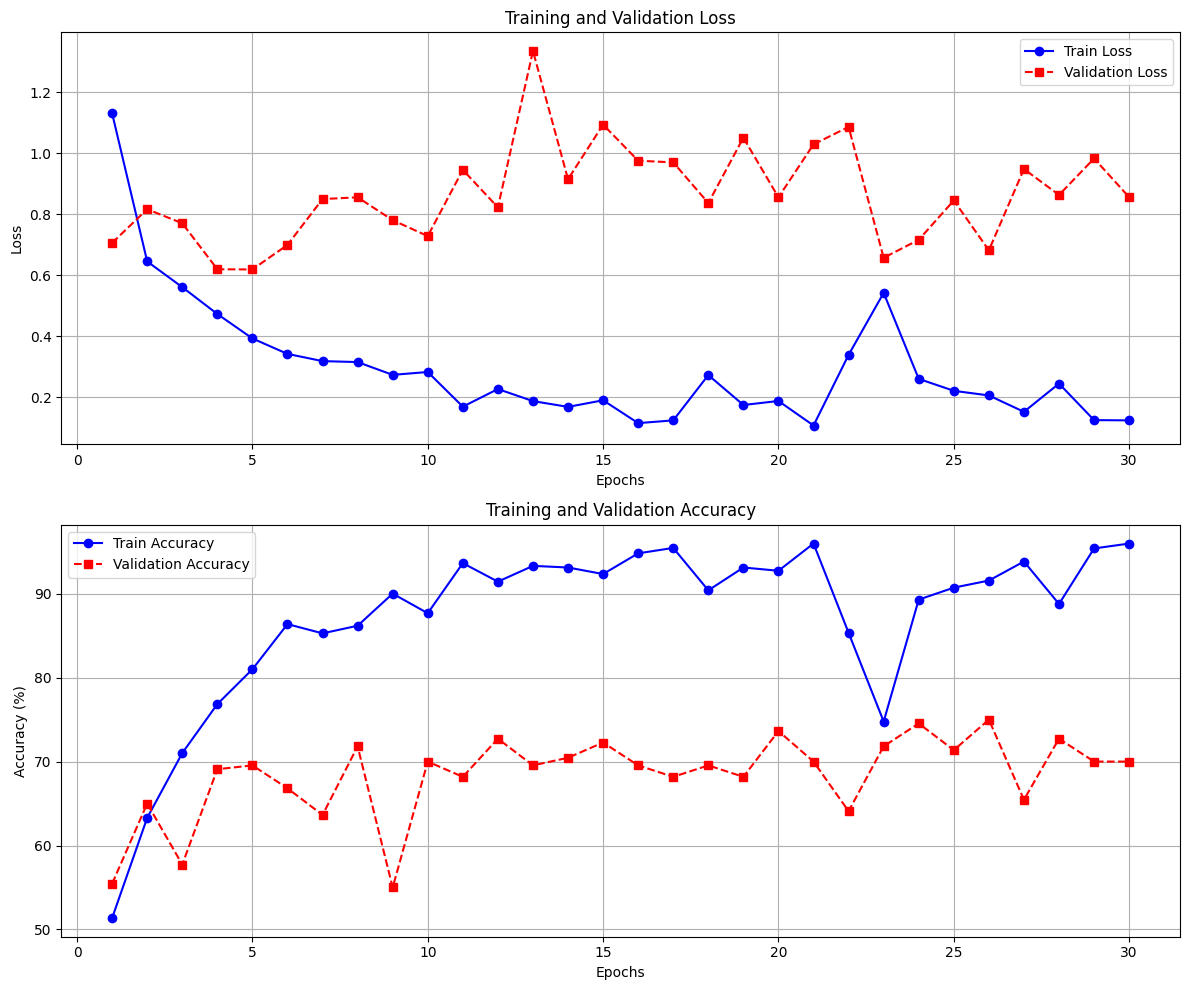


Final Training Metrics:
  Loss: 0.1243
  Accuracy: 95.98%

Final Validation Metrics:
  Loss: 0.8555
  Accuracy: 70.00%


In [16]:
num_epochs = 30
best_val_f1 = 0.0

# Lists to store metrics for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Lists to store predictions and targets for training metrics
    train_predictions = []
    train_targets = []
    
    for batch_idx, (inputs, targets,_) in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        
        # Store predictions and targets
        train_predictions.extend(predicted.cpu().numpy())
        train_targets.extend(targets.cpu().numpy())
    
    # Calculate training metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    
    # Store metrics for plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Calculate training metrics for each class
    train_metrics = calculate_per_class_metrics(np.array(train_targets), np.array(train_predictions))
    
    # Evaluate on validation set
    val_loss, val_accuracy, val_metrics = evaluate(model, val_loader, device)
    
    # Store validation metrics for plotting
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    print(f'  Train - Loss: {train_loss:.4f}, Acc: {train_accuracy:.2f}%')
    print(f'    Class 0 - Precision: {train_metrics["per_class"]["precision"][0]:.4f}, Recall: {train_metrics["per_class"]["recall"][0]:.4f}, F1: {train_metrics["per_class"]["f1"][0]:.4f}')
    print(f'    Class 1 - Precision: {train_metrics["per_class"]["precision"][1]:.4f}, Recall: {train_metrics["per_class"]["recall"][1]:.4f}, F1: {train_metrics["per_class"]["f1"][1]:.4f}')
    
    print(f'  Val   - Loss: {val_loss:.4f}, Acc: {val_accuracy:.2f}%')
    print(f'    Class 0 - Precision: {val_metrics["per_class"]["precision"][0]:.4f}, Recall: {val_metrics["per_class"]["recall"][0]:.4f}, F1: {val_metrics["per_class"]["f1"][0]:.4f}')
    print(f'    Class 1 - Precision: {val_metrics["per_class"]["precision"][1]:.4f}, Recall: {val_metrics["per_class"]["recall"][1]:.4f}, F1: {val_metrics["per_class"]["f1"][1]:.4f}')
    
    # Save model checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint_path = os.path.join(save_dir, f'model_epoch_{epoch+1}.pt')
        save_checkpoint(model, optimizer, epoch+1, train_loss, train_accuracy, checkpoint_path)
    
    # Save the best model based on average of F1 scores for both classes
    val_f1_avg = (val_metrics['per_class']['f1'][0] + val_metrics['per_class']['f1'][1]) / 2
    if val_f1_avg > best_val_f1:
        best_val_f1 = val_f1_avg
        best_model_path = os.path.join(save_dir, 'model_best.pt')
        save_checkpoint(model, optimizer, epoch+1, val_loss, val_accuracy, best_model_path)
        print(f"New best model saved with average validation F1 score: {val_f1_avg:.4f}")

# Plot training and validation metrics
plt.figure(figsize=(12, 10))

# Plot Loss
plt.subplot(2, 1, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o', linestyle='-', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s', linestyle='--', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(2, 1, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', marker='o', linestyle='-', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='s', linestyle='--', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

# Print final metrics
print("\nFinal Training Metrics:")
print(f"  Loss: {train_losses[-1]:.4f}")
print(f"  Accuracy: {train_accuracies[-1]:.2f}%")

print("\nFinal Validation Metrics:")
print(f"  Loss: {val_losses[-1]:.4f}")
print(f"  Accuracy: {val_accuracies[-1]:.2f}%")

In [17]:
print("\n=== Final Evaluation on Test Set (Best Model) ===")
checkpoint = torch.load(os.path.join(save_dir, 'model_best.pt'))
model.load_state_dict(checkpoint['model_state_dict'])
val_loss, val_accuracy, val_metrics = evaluate(model, val_loader, device, print_metrics=True)

print(f"\nTest Results Summary:")
print(f"  Loss: {val_loss:.4f}")
print(f"  Accuracy: {val_accuracy:.2f}%")
print(f"  Class 0 - Precision: {val_metrics['per_class']['precision'][0]:.4f}, Recall: {val_metrics['per_class']['recall'][0]:.4f}, F1: {val_metrics['per_class']['f1'][0]:.4f}")
print(f"  Class 1 - Precision: {val_metrics['per_class']['precision'][1]:.4f}, Recall: {val_metrics['per_class']['recall'][1]:.4f}, F1: {val_metrics['per_class']['f1'][1]:.4f}")

# Save final model
final_checkpoint_path = os.path.join(save_dir, 'model_final.pt')
save_checkpoint(model, optimizer, num_epochs, train_loss, train_accuracy, final_checkpoint_path)


=== Final Evaluation on Test Set (Best Model) ===


/tmp/ipykernel_31/4185239666.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(save_dir, 'model_best.pt'))


Accuracy: 75.00%

Weighted Metrics:
  Precision: 0.7614
  Recall: 0.7500
  F1 Score: 0.7472

Per-Class Metrics:
  Class 0 - Precision: 0.8161, Recall: 0.6455, F1: 0.7208
  Class 1 - Precision: 0.7068, Recall: 0.8545, F1: 0.7737

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.65      0.72       110
           1       0.71      0.85      0.77       110

    accuracy                           0.75       220
   macro avg       0.76      0.75      0.75       220
weighted avg       0.76      0.75      0.75       220


Confusion Matrix:
[[71 39]
 [16 94]]

Confusion Matrix Explanation:
  True Negatives (Class 0 correctly predicted): 71
  False Positives (Class 0 incorrectly predicted as Class 1): 39
  False Negatives (Class 1 incorrectly predicted as Class 0): 16
  True Positives (Class 1 correctly predicted): 94

Test Results Summary:
  Loss: 0.6811
  Accuracy: 75.00%
  Class 0 - Precision: 0.8161, Recall: 0.6455, F1: 0.7208
  Cla

In [18]:
print("\n=== Final Evaluation on Test Set (Best Model) ===")
checkpoint = torch.load(os.path.join(save_dir, 'model_best.pt'))
model.load_state_dict(checkpoint['model_state_dict'])
test_loss, test_accuracy, test_metrics = evaluate(model, test_balanced_loader, device, print_metrics=True)

print(f"\nTest Results Summary:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_accuracy:.2f}%")
print(f"  Class 0 - Precision: {test_metrics['per_class']['precision'][0]:.4f}, Recall: {test_metrics['per_class']['recall'][0]:.4f}, F1: {test_metrics['per_class']['f1'][0]:.4f}")
print(f"  Class 1 - Precision: {test_metrics['per_class']['precision'][1]:.4f}, Recall: {test_metrics['per_class']['recall'][1]:.4f}, F1: {test_metrics['per_class']['f1'][1]:.4f}")

# Save final model
final_checkpoint_path = os.path.join(save_dir, 'model_final.pt')
save_checkpoint(model, optimizer, num_epochs, train_loss, train_accuracy, final_checkpoint_path)


=== Final Evaluation on Test Set (Best Model) ===


/tmp/ipykernel_31/181927273.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(save_dir, 'model_best.pt'))


Accuracy: 63.68%

Weighted Metrics:
  Precision: 0.6685
  Recall: 0.6368
  F1 Score: 0.6188

Per-Class Metrics:
  Class 0 - Precision: 0.7417, Recall: 0.4198, F1: 0.5361
  Class 1 - Precision: 0.5954, Recall: 0.8538, F1: 0.7016

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.42      0.54       212
           1       0.60      0.85      0.70       212

    accuracy                           0.64       424
   macro avg       0.67      0.64      0.62       424
weighted avg       0.67      0.64      0.62       424


Confusion Matrix:
[[ 89 123]
 [ 31 181]]

Confusion Matrix Explanation:
  True Negatives (Class 0 correctly predicted): 89
  False Positives (Class 0 incorrectly predicted as Class 1): 123
  False Negatives (Class 1 incorrectly predicted as Class 0): 31
  True Positives (Class 1 correctly predicted): 181

Test Results Summary:
  Loss: 0.8613
  Accuracy: 63.68%
  Class 0 - Precision: 0.7417, Recall: 0.4198, F1: 0.5361

In [19]:
def evaluate_clip_level(model, test_loader, device):
    """
    Evaluates the model at clip level for an embedding comparison dataset.
    For each reference clip, checks if the model correctly identifies the matching utterance
    with the highest probability.
    
    Args:
        model: The trained model
        test_loader: DataLoader for test data
        device: Device to run evaluation on
    
    Returns:
        clip_accuracy: Accuracy at clip level
        clip_results: Dictionary with detailed results for each clip
    """
    model.eval()
    reference_clips = {}  # Dictionary to store clip-level data
    
    with torch.no_grad():
        for inputs, targets, clip_ids in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            # Get probabilities for class 1 (matching)
            probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Get probability for class 1
            
            # Process each sample in the batch
            for i in range(len(targets)):
                clip_1 = clip_ids['clip_1'][i]
                clip_2 = clip_ids['clip_2'][i]
                prob = probabilities[i].item()
                target = targets[i].item()
                
                # Parse clip_1 to get reference clip ID and utterance ID
                # Assuming format like "20-01-01" where "20-01" is the reference clip
                # and "01" is the utterance ID
                parts = clip_1.split('-')
                ref_clip_id = '-'.join(parts[:-1])  # Everything before the last part
                utterance_id = parts[-1]  # The last part
                
                # Initialize reference clip entry if not exists
                if ref_clip_id not in reference_clips:
                    reference_clips[ref_clip_id] = {
                        'comparisons': [],
                        'true_match': None
                    }
                
                # Store this comparison
                reference_clips[ref_clip_id]['comparisons'].append({
                    'utterance_id': utterance_id,
                    'compared_to': clip_2,
                    'probability': prob,
                    'is_match': target == 1
                })
                
                # If this is a true match, record it
                if target == 1:
                    reference_clips[ref_clip_id]['true_match'] = utterance_id
    
    # Evaluate clip-level accuracy
    correct_clips = 0
    total_clips = 0
    clip_results = {}
    
    for ref_clip_id, clip_data in reference_clips.items():
        # Skip clips with no true match or no comparisons
        if not clip_data['true_match'] or not clip_data['comparisons']:
            continue
        
        # Group by utterance_id and find highest probability for each
        utterances = {}
        for comp in clip_data['comparisons']:
            utt_id = comp['utterance_id']
            if utt_id not in utterances or comp['probability'] > utterances[utt_id]['probability']:
                utterances[utt_id] = {
                    'probability': comp['probability'],
                    'is_match': comp['is_match']
                }
        
        # Find utterance with highest probability
        if not utterances:
            continue
            
        predicted_utterance = max(utterances.items(), key=lambda x: x[1]['probability'])[0]
        true_match = clip_data['true_match']
        
        # Check if prediction matches the true match
        is_correct = predicted_utterance == true_match
        
        if is_correct:
            correct_clips += 1
        total_clips += 1
        
        # Store results
        clip_results[ref_clip_id] = {
            'predicted_utterance': predicted_utterance,
            'true_match': true_match,
            'is_correct': is_correct,
            'all_utterances': utterances
        }
    
    # Calculate clip-level accuracy
    clip_accuracy = correct_clips / total_clips if total_clips > 0 else 0
    
    return clip_accuracy, clip_results

In [20]:
def evaluate_clip_level_for_pair_dataset(model, test_loader, device):
    """
    Evaluates the model at clip level for an embedding comparison dataset.
    Builds a ranked list of clip2 options for each clip1 and checks if the true
    match is ranked highest.
    
    Args:
        model: The trained model
        test_loader: DataLoader for test data
        device: Device to run evaluation on
    
    Returns:
        clip_accuracy: Accuracy at clip level
        clip_results: Dictionary with detailed results for each clip
    """
    model.eval()
    clip_comparisons = {}  # Dictionary to store all comparisons for each clip
    
    with torch.no_grad():
        for inputs, targets, clip_ids in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            # Get probabilities for class 1 (matching)
            probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Get probability for class 1
            
            # Process each sample in the batch
            for i in range(len(targets)):
                clip_1 = clip_ids['clip_1'][i]
                clip_2 = clip_ids['clip_2'][i]
                prob = probabilities[i].item()
                target = targets[i].item()
                
                # Initialize entry for this clip_1 if not exists
                if clip_1 not in clip_comparisons:
                    clip_comparisons[clip_1] = []
                
                # Store this comparison
                clip_comparisons[clip_1].append({
                    'compared_to': clip_2,
                    'probability': prob,
                    'is_match': target == 1
                })
    
    # Evaluate clip-level accuracy
    correct_clips = 0
    total_clips = 0
    clip_results = {}
    
    for clip_1, comparisons in clip_comparisons.items():
        # Skip clips with no comparisons
        if not comparisons:
            continue
        
        # Sort comparisons by probability (descending)
        sorted_comparisons = sorted(comparisons, key=lambda x: x['probability'], reverse=True)
        
        # Find the highest ranked true match
        true_matches = [comp for comp in sorted_comparisons if comp['is_match']]
        
        # Skip clips with no true matches
        if not true_matches:
            continue
            
        # Check if the highest probability is a true match
        highest_prob_comparison = sorted_comparisons[0]
        is_correct = highest_prob_comparison['is_match']
        
        if is_correct:
            correct_clips += 1
        total_clips += 1
        
        # Store results
        clip_results[clip_1] = {
            'predicted_match': highest_prob_comparison['compared_to'],
            'prediction_probability': highest_prob_comparison['probability'],
            'true_matches': [m['compared_to'] for m in true_matches],
            'is_correct': is_correct,
            'all_comparisons': sorted_comparisons
        }
    
    # Calculate clip-level accuracy
    clip_accuracy = correct_clips / total_clips if total_clips > 0 else 0
    
    return clip_accuracy, clip_results


def visualize_pair_evaluation(clip_results, save_path='pair_evaluation_visualization.png'):
    """
    Visualizes the evaluation results for pair comparison evaluation
    
    Args:
        clip_results: Dictionary with clip-level results
        save_path: Path to save the visualization
    """
    # Count correct and incorrect predictions
    correct = sum(1 for result in clip_results.values() if result['is_correct'])
    incorrect = len(clip_results) - correct
    
    # Create figures
    plt.figure(figsize=(12, 10))
    
    # Pie chart for accuracy
    plt.subplot(2, 1, 1)
    plt.pie([correct, incorrect], labels=['Correct', 'Incorrect'], 
            autopct='%1.1f%%', colors=['green', 'red'])
    plt.title('Clip-level Prediction Accuracy')
    
    # Bar chart for probability distribution
    plt.subplot(2, 1, 2)
    
    # Extract probability differences between predicted and true matches
    prob_diffs = []
    for clip_id, data in clip_results.items():
        if not data['is_correct'] and data['true_matches']:
            # Find the highest probability true match
            true_match_probs = [comp['probability'] for comp in data['all_comparisons'] 
                                if comp['compared_to'] in data['true_matches']]
            if true_match_probs:
                highest_true_prob = max(true_match_probs)
                pred_prob = data['prediction_probability']
                prob_diffs.append(pred_prob - highest_true_prob)
    
    if prob_diffs:
        plt.hist(prob_diffs, bins=20, color='blue', alpha=0.7)
        plt.axvline(x=0, color='red', linestyle='--')
        plt.xlabel('Probability Difference (Predicted - True)')
        plt.ylabel('Count')
        plt.title('Distribution of Probability Differences in Incorrect Predictions')
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    
    # Create a table of incorrect predictions
    incorrect_clips = [(clip_id, data) for clip_id, data in clip_results.items() if not data['is_correct']]
    
    if incorrect_clips:
        plt.figure(figsize=(12, 8))
        plt.axis('off')
        plt.title('Sample of Incorrect Clip Predictions')
        
        table_data = []
        headers = ['Clip ID', 'Predicted Match', 'True Match(es)', 'Pred. Prob.', 'True Prob.']
        
        for i, (clip_id, data) in enumerate(incorrect_clips[:10]):  # Show top 10
            pred_match = data['predicted_match']
            true_matches = ', '.join(data['true_matches'])
            pred_prob = data['prediction_probability']
            
            # Get probability of the highest probability true match
            true_match_comps = [comp for comp in data['all_comparisons'] 
                               if comp['compared_to'] in data['true_matches']]
            highest_true_prob = max([comp['probability'] for comp in true_match_comps]) if true_match_comps else 'N/A'
            
            table_data.append([
                clip_id, 
                pred_match, 
                true_matches, 
                f"{pred_prob:.4f}", 
                f"{highest_true_prob:.4f}" if highest_true_prob != 'N/A' else 'N/A'
            ])
        
        plt.table(cellText=table_data, colLabels=headers, loc='center', cellLoc='center')
        plt.savefig('incorrect_predictions.png')
        plt.show()

In [21]:
clip_accuracy1, clip_results1 = evaluate_clip_level(model, test_loader, device)

# Print results
print(f"\nClip-level Accuracy: {clip_accuracy1:.4f}")
print(f"Total clips evaluated: {len(clip_results1)}")


Clip-level Accuracy: 0.8534
Total clips evaluated: 191


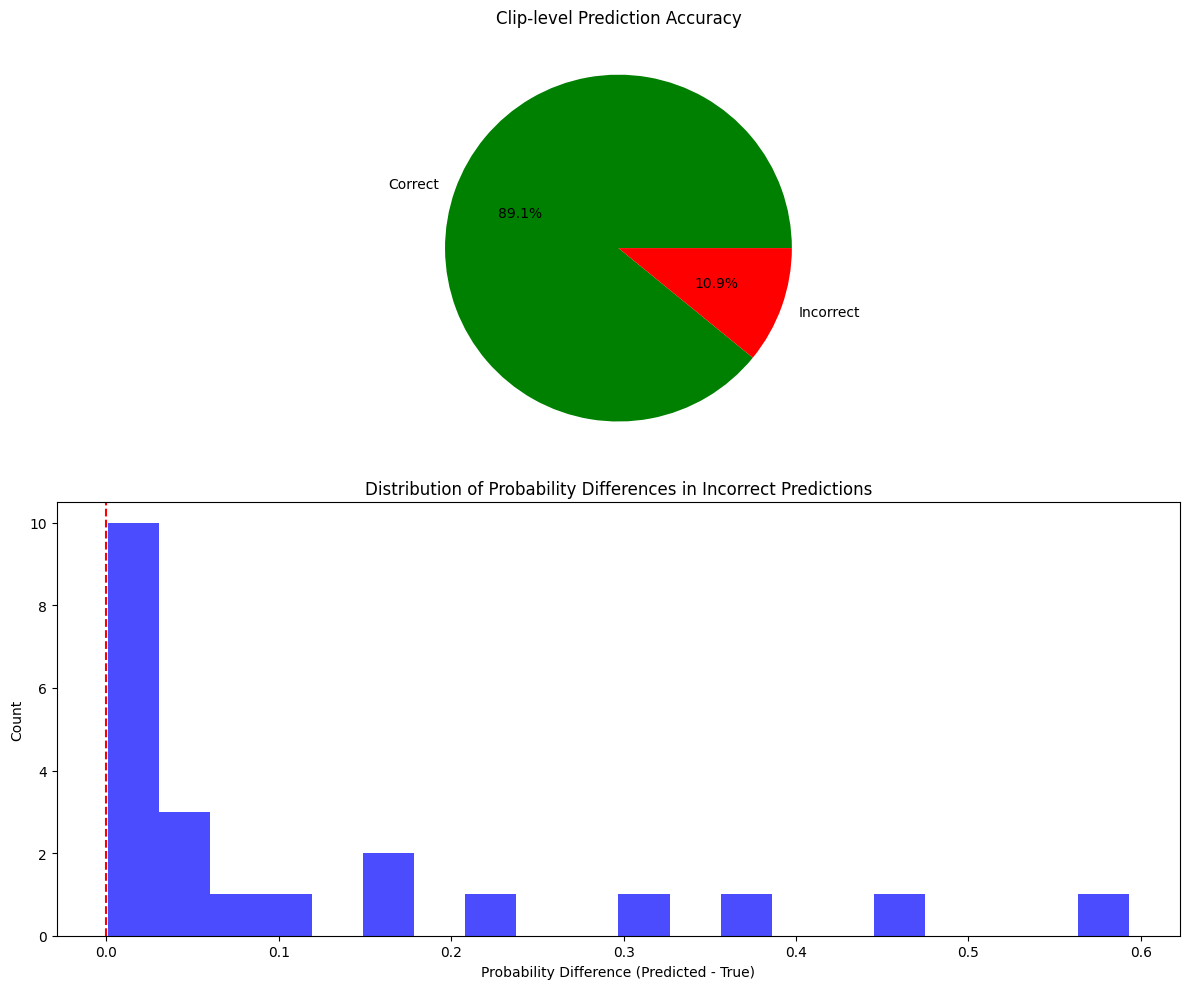

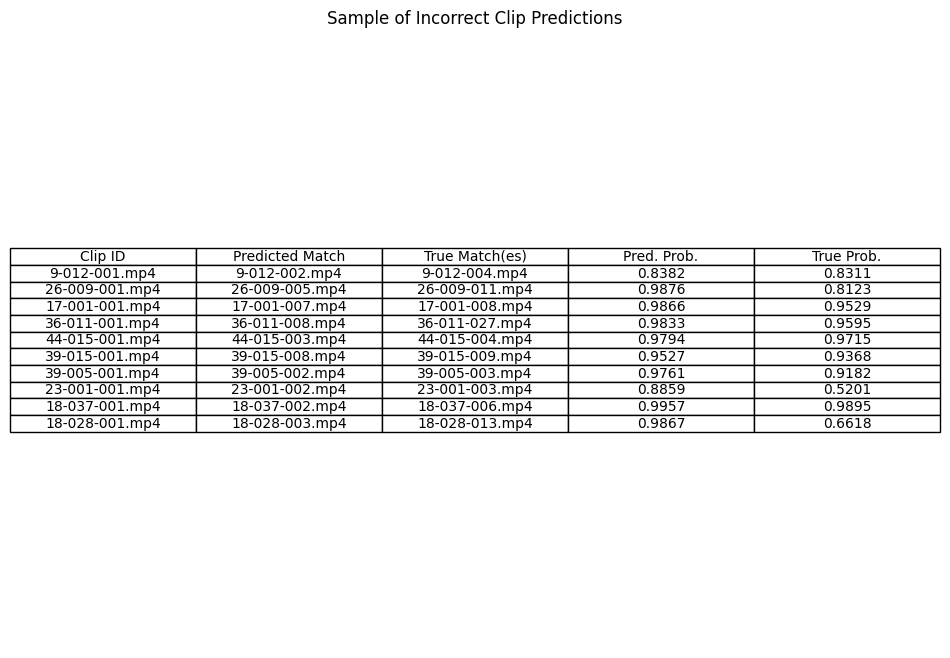

In [22]:
clip_accuracy, clip_results=evaluate_clip_level_for_pair_dataset(model, test_loader, device)
visualize_pair_evaluation(clip_results)

In [24]:
import pandas as pd

cnt = 0
df = pd.read_csv('/kaggle/input/dataset-embs/combined_data.csv')

ref_clip_id = "10-070"  # Or whatever your reference is

for clip_id, data in clip_results.items():
    if clip_id.startswith(ref_clip_id):
        # Find matching rows in the dataframe
        filtered_rows = df[(df['clip_1'] == clip_id) | (df['clip_2'] == clip_id)]

        print(f"\n=== Clip ID: {clip_id} ===")
        for _, row in filtered_rows.iterrows():
            print("Utterance 1:", row['utterance_text_1'])
            print("Utterance 2:", row['utterance_text_2'])
            print("---")

        cnt += 1



=== Clip ID: 10-070-001.mp4 ===
Utterance 1: And it's him last first, Lou.
Utterance 2: What?
---
Utterance 1: And it's him last first, Lou.
Utterance 2: Okay.
---
Utterance 1: And it's him last first, Lou.
Utterance 2: Oh!
---


In [25]:
import torch

def load_checkpoint(model, optimizer, checkpoint_path, device='cuda'):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    accuracy = checkpoint['accuracy']
    
    print(f"Checkpoint loaded from '{checkpoint_path}'")
    print(f"  -> Epoch: {epoch}")
    print(f"  -> Loss: {loss:.4f}")
    print(f"  -> Accuracy: {accuracy:.2f}%")
    
    return model, optimizer, epoch


In [26]:
df = pd.read_csv('/kaggle/input/dataset-embs/combined_data.csv')
filtered = df[df['clip_1'].str.startswith('45-001') | df['clip_2'].str.startswith('45-001')]
print(filtered)

      Unnamed: 0          clip_1     utterance_text_1          clip_2  \
2775        2775  45-001-001.mp4  You look beautiful.  45-001-002.mp4   

     utterance_text_2 parent_folder  class  
2775       Thank you.        45-001      1  


In [27]:
csv_file = '/kaggle/input/dataset-embs/combined_data.csv'


In [28]:
clip_accuracy, clip_results=evaluate_clip_level_for_pair_dataset(model, test_loader, device)

In [29]:
df = pd.read_csv('/kaggle/input/dataset-embs/combined_data.csv')

ref_clip_id = "10-070"  # Or whatever your reference is

for clip_id, data in clip_results.items():
    if clip_id.startswith(ref_clip_id):
        # Find matching rows in the dataframe
        filtered_rows = df[(df['clip_1'] == clip_id) | (df['clip_2'] == clip_id)]

        print(f"\n=== Clip ID: {clip_id} ===")
        for _, row in filtered_rows.iterrows():
            print("Utterance 1:", row['utterance_text_1'])
            print("Utterance 2:", row['utterance_text_2'])
            print("---")
            break

        cnt += 1


=== Clip ID: 10-070-001.mp4 ===
Utterance 1: And it's him last first, Lou.
Utterance 2: What?
---


In [33]:
def eval_clip(prefix="10-070"):
    """
    Prints all utterances in df that start with the given prefix,
    labeling them as cause and effect, then prints all results from 
    clip_results that start with the same prefix.
    """
    # Part 1: Print all utterances in df that start with the prefix
    print(f"\n=== All utterances in dataframe with clips starting with '{prefix}' ===")
    
    # Filter dataframe for rows where either clip_1 or clip_2 starts with the prefix
    filtered_df = df[df['clip_1'].str.startswith(prefix) | df['clip_2'].str.startswith(prefix)]
    
    for idx, row in filtered_df.iterrows():
        print(f"\nRow {idx}:")
        print(f"Clip 1: {row['clip_1']} (CAUSE)")
        print(f"Clip 2: {row['clip_2']} (EFFECT)")
        print(f"Cause utterance: {row['utterance_text_1']}")
        print(f"Effect utterance: {row['utterance_text_2']}")
        print("---")
    
    # Part 2: Print all results from clip_results that start with the prefix
    print(f"\n=== All results in clip_results with clips starting with '{prefix}' ===")
    
    count = 0
    for clip_id, data in clip_results.items():
        if clip_id.startswith(prefix):
            print(f"\nCause Clip ID: {clip_id}")
            print(f"Predicted effect match: {data['predicted_match']}")
            print(f"Prediction probability: {data['prediction_probability']:.4f}")
            print(f"True effect matches: {data['true_matches']}")
            print(f"Is correct: True")
            
            # Find the matching row to display the actual utterances
            cause_utterance = ""
            effect_utterance = ""
            
            # Look for the clip_id in clip_1 column (as cause)
            cause_rows = filtered_df[filtered_df['clip_1'] == clip_id]
            if not cause_rows.empty:
                row = cause_rows.iloc[0]
                cause_utterance = row['utterance_text_1']
                effect_utterance = row['utterance_text_2']
            else:
                # Look for the clip_id in clip_2 column (as effect)
                effect_rows = filtered_df[filtered_df['clip_2'] == clip_id]
                if not effect_rows.empty:
                    row = effect_rows.iloc[0]
                    cause_utterance = row['utterance_text_2']  # Reversed since clip_id is in clip_2
                    effect_utterance = row['utterance_text_1']  # Reversed since clip_id is in clip_2
            
            print(f"Cause utterance: {cause_utterance}")
            print(f"Effect utterance: {effect_utterance}")
            
            count += 1
    
    print(f"\nTotal clips in df with prefix '{prefix}': {len(filtered_df)}")
    print(f"Total clips in results with prefix '{prefix}': {count}")

# Usage:
# print_clip_data_with_cause_effect("10-070")

In [36]:
clip_id = "20-025"
eval_clip(clip_id)


=== All utterances in dataframe with clips starting with '20-025' ===

Row 4625:
Clip 1: 20-025-001.mp4 (CAUSE)
Clip 2: 20-025-002.mp4 (EFFECT)
Cause utterance: Dr. Amy Farah Fowler.
Effect utterance: Wow.
---

Row 4626:
Clip 1: 20-025-001.mp4 (CAUSE)
Clip 2: 20-025-003.mp4 (EFFECT)
Cause utterance: Dr. Amy Farah Fowler.
Effect utterance: Amy, you look amazing.
---

Row 4627:
Clip 1: 20-025-002.mp4 (CAUSE)
Clip 2: 20-025-003.mp4 (EFFECT)
Cause utterance: Wow.
Effect utterance: Amy, you look amazing.
---

=== All results in clip_results with clips starting with '20-025' ===

Cause Clip ID: 20-025-001.mp4
Predicted effect match: 20-025-002.mp4
Prediction probability: 0.9978
True effect matches: ['20-025-003.mp4']
Is correct: True
Cause utterance: Dr. Amy Farah Fowler.
Effect utterance: Wow.

Total clips in df with prefix '20-025': 3
Total clips in results with prefix '20-025': 1
